In [18]:
import sionna as sn

In [28]:
BATCH_SIZE = 1
NUM_BS_ANT = 4
NUM_UT = 7
BS_HEIGHT = 10.0
MAX_UT_HEIGHT = 30

NUM_STREAMS_PER_TX = 2

In [29]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=14,
    fft_size=76,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[2,11]
)

resource_grid.show();

AssertionError: `num_effective_subcarriers` must be an integer multiple of
            `num_tx`*`num_streams_per_tx`.

In [ ]:
constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)
binary_source = sn.utils.BinarySource()

mapper = sn.mapping.Mapper(constellation=constellation)
demapper = sn.mapping.Demapper('app', constellation=constellation)

ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, hard_out=True)

In [20]:
CARRIER_FREQUENCY = 2.6e9

ut_array = sn.channel.tr38901.Antenna(
    polarization='single',
    polarization_type='V',
    antenna_pattern='38.901',
    carrier_frequency=CARRIER_FREQUENCY
)

bs_array = sn.channel.tr38901.AntennaArray(
    num_rows=1,
    num_cols=NUM_BS_ANT,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=CARRIER_FREQUENCY
)

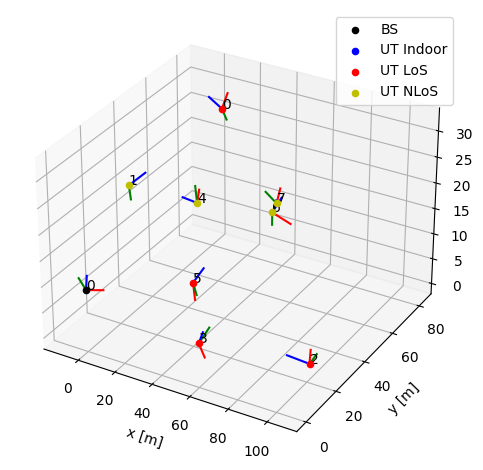

In [22]:
channel_model=sn.channel.tr38901.UMi(
  carrier_frequency=CARRIER_FREQUENCY,
  o2i_model='low',
  ut_array=ut_array,
  bs_array=bs_array,
  direction='uplink',
  enable_pathloss=False,
  enable_shadow_fading=False
)

topology = sn.channel.gen_single_sector_topology(
    batch_size=BATCH_SIZE,
    indoor_probability=0,
    num_ut=NUM_UT,
    scenario='umi',
    bs_height=BS_HEIGHT,
    max_ut_height=MAX_UT_HEIGHT,
)

channel_model.set_topology(*topology)

channel_model.show_topology();